# Milestone 2 - CS109B Project Group 29
**"Predicting Movie Genres"**<br>
**CS109B (Spring 2017) Final Project Group 29**<br>
Calvin J Chiew, Tim Hagmann, Ji Hua<br>
TF: Rashmi Banthia<br>

## Deliverables

- Discussion about the imbalanced nature of the data and how you want to address it
- Description of your data
- What does your choice of Y look like?
- Which features do you choose for X and why?
- How do you sample your data, how many samples, and why?

## Import Libraries

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
from bs4 import BeautifulSoup
import urllib
from urllib import urlopen
import threading
from threading import Timer
from time import time, sleep
import io

## Data Sampling

First, we used the TMDb API to scrape information on movies that have `tmdb_id` of 1 through 160,000. About 60,000 of these `tmdb_id`'s were empty, returning about 100,000 actual records.

Given that `tmdb_id`'s are not assigned in chronological order or in any particular pattern, this 100,000 movies represent a **random** sample of all movies listed on TMDb (estimated to be around 300,000). We chose 100,000 as we believe it is a sufficiently large sample size to develop our traditional ML and deep learning models.

We dropped about 30,000 records that were missing poster paths and `imdb_id`'s, leaving us with about 70,000 movies. Finally, we extracted the additional metadata we wanted for these movies from IMDb and matched them to the TMDb records based on `imdb_id`.

You can view the raw data file we gathered on our GitHub repository here: https://github.com/greenore/deep-learning-project/tree/master/milestone2/data

---

## Outcome Variable (Y)

The outcome variable is the movie genre, which is classified into 19 categories by TMDb (namely Adventure, Fantasy, Animation, Drama, Horror, Action, Comedy, History, Western, Thriller, Crime, Documentary, Science Fiction, Mystery, Music, Romance, Family, War and Foreign). We decided against regrouping the genres because even if we had chosen to do so, we would have only collapsed a few groups (eg. Action-Adventure, Thriller-Crime-Mystery) based on our genre pair analysis in earlier EDA (see Milestone 1). We did not feel that this small reduction in genre categories would make a significant difference in the larger picture. To simplify the problem, we will also not use the genre classifications on IMDb.

In addition, each movie may fall into multiple genres, ie. this is a multi-label problem. To address this issue, we coded the outcome into 19 columns of binary (1/0) flags, one for each of the 19 TMDb genres.

---

## Predictor Variables (X)

We have two sets of data, one with movie posters as features, and the other with movie metadata. For the former, we downloaded w500 resolution movie posters from TMDb. For the latter, we have chosen to include the following features:

*Extracted from TMDb*
- Title
- Plot summary
- Production company
- Release date
- Runtime (mins)
- Budget (US\$)
- Revenue (US\$)
- Popularity (on scale of 1-10)
- Average user rating (on scale of 1-10)

*Extracted from IMDb*
- Producer (first name listed)
- Director (first name listed)
- Writer (first name listed)
- Cast (first 4 names listed)
- Country of origin / language
- Picture rating (US MPAA categories eg. PG-13, R-21)

These features were chosen based on our prior beliefs about what are potential predictors of movie genre (see Milestone 1).



---

## Bag-of-Words Analysis (for Title & Plot)

In this section, we use bag-of-words analysis to convert the title and plot summaries into features.

In [56]:
# load csv file
raw = pd.read_table('tmdb_movie_info_100k.txt')

# concatenate title and plot together 
raw['title_plot'] = raw['title'].astype(str) + ' ' + raw['plot'].astype(str)

# drop all columns except title and plot
raw = raw[['tmdb_id', 'imdb_id', 'title_plot']]

# view first few rows
raw.head()

,tmdb_id,imdb_id,title_plot
0,2,0094675,Ariel Taisto Kasurinen is a Finnish coal miner...
1,3,0092149,Shadows in Paradise An episode in the life of ...
2,5,0113101,Four Rooms It's Ted the Bellhop's first night ...
3,6,0107286,"Judgment Night While racing to a boxing match,..."
4,8,0825671,Life in Loops (A Megacities RMX) Timo Novotny ...


In [57]:
# create bag-of-words matrix
from sklearn.feature_extraction.text import TfidfVectorizer
# ignore stop words and only consider words that make up at least 1% of the corpus
vectorizer = TfidfVectorizer(stop_words='english', min_df=0.01)
corpus = raw['title_plot'].values
X = vectorizer.fit_transform(corpus)
vocab = vectorizer.get_feature_names()
len(vocab)

389

In [58]:
print(vocab)

[u'accident', u'action', u'adventure', u'affair', u'age', u'agent', u'america', u'american', u'amp', u'army', u'arrives', u'art', u'artist', u'attempt', u'attempts', u'away', u'baby', u'bad', u'band', u'based', u'battle', u'beautiful', u'begin', u'begins', u'best', u'big', u'black', u'blood', u'body', u'book', u'boss', u'boy', u'boyfriend', u'boys', u'break', u'bring', u'brings', u'british', u'brother', u'brothers', u'business', u'called', u'car', u'career', u'case', u'caught', u'century', u'chance', u'change', u'characters', u'child', u'childhood', u'children', u'city', u'class', u'classic', u'close', u'college', u'come', u'comedy', u'comes', u'coming', u'company', u'concert', u'control', u'cop', u'country', u'couple', u'course', u'crew', u'crime', u'criminal', u'dangerous', u'dark', u'daughter', u'david', u'day', u'days', u'dead', u'deadly', u'deal', u'death', u'decide', u'decides', u'despite', u'detective', u'die', u'dies', u'different', u'directed', u'director', u'discover', u'disc

There are 389 words in the vocabulary, as shown above. We view the final weighted frequency matrix which was generated using Term Frequency times Inverse Document Frequency (tf-idf).

In [59]:
bagofwords = pd.DataFrame(X.toarray(), columns=vocab)
bagofwords = bagofwords.add_prefix('word_')
bagofwords.head()

,word_accident,word_action,word_adventure,word_affair,word_age,word_agent,word_america,word_american,word_amp,word_army,...,word_work,word_working,word_works,word_world,word_writer,word_written,word_year,word_years,word_york,word_young
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.665059,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.394097,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.184482,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.119018,0.0,0.180166,0.0,0.0,0.165786,0.0


---

## Converting Posters to Features and Further Data Cleanup

(Tim to assist with this section)
- convert posters to pixel features
- ?apply PCA, get top PCs
- further cleanup/data manipulation eg. production companies, release date
- get dummy variables for categorical variables

### Preparing the Coding Environment
The analysis was performed using a R-Kernel. In order to reproduce the results, the kernel has to be switched. To install the R essentials in the current environment, execute the following code in your system prompt:

```bash
conda install -c r r-essentials
```

**Machine:**   Windows 7 | Intel i7-3540M @ 3.00GHz | 16.00 GB RAM

**R Version:** Microsoft R Open 3.3.2 -- "Sincere Pumpkin Patch"

We need to set some global options for the R environment. The only thing that one might have to change is the .libPaths part.

In [1]:
## Options
options(scipen=10)
update_package <- FALSE
options(java.parameters="-Xmx6g")
options(warn=-1)

# Set the library/packages path
options(repos = c(CRAN = "https://cran.revolutionanalytics.com"))
.libPaths("C:/Local/R/win-library/3.2")

# Set local time
Sys.setenv(LANG = "en")
Sys.setlocale("LC_TIME", "C")

[1] "C"

Here, we load some project specific packages and functions. `01_init.R` is just a helper script, `02_packages.R` loads and installs the required packages and libraries, and `03_functions.R` loads functions specifically written for this analysis.

In [2]:
## Init files (always execute, eta: 10s)
suppressMessages(source("scripts/01_init.R"))                   # Helper functions to load packages
suppressMessages(source("scripts/02_packages.R"))               # Load all necessary packages
suppressMessages(source("scripts/03_functions.R"))              # Load project specific functions

Set Java path to C:/Program Files (x86)/Java/jre7

### Preparing the Data
First, we load the data gathered from TMDb.

### Final Dataframe

Finally, we take a look at the final dataframe, which has a total of () observations and () variables.

---

## Imbalanced Data

Here, we visualize the imbalanced nature of our data by plotting the number of movies in each genre.

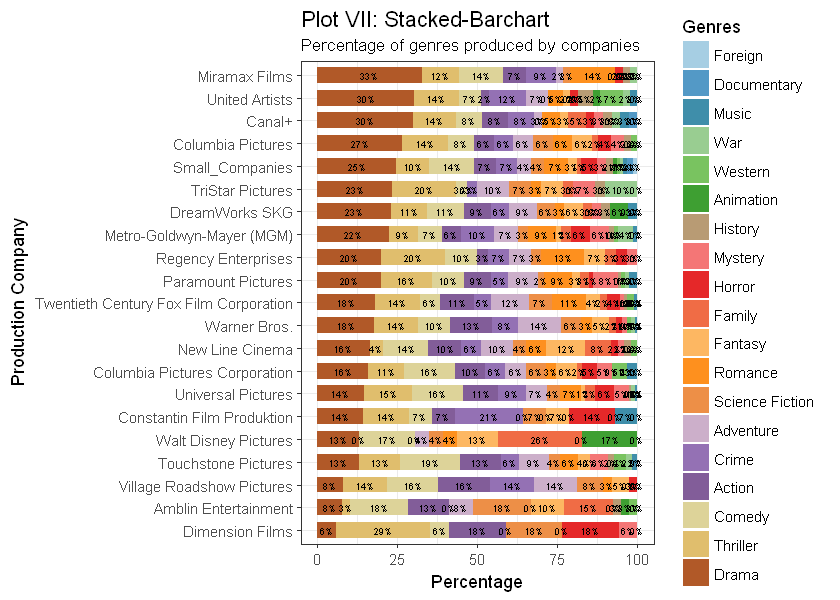

In [13]:
ggplot(df_company_perc, aes(x=production_company, y=percentage, fill=genres)) +
  geom_bar(position=position_stack(), stat="identity", width = .7) +
  coord_flip() + 
  theme_bw() +
  geom_text(aes(label=paste0(round(percentage), "%")), 
            position=position_stack(vjust=0.5), size=2) +
  labs(title="Plot VII: Stacked-Barchart",
       subtitle="Percentage of genres produced by companies") +
  xlab("Production Company") +
  ylab("Percentage") +
  scale_fill_manual(values=getPalette(colourCount), name="Genres")

From the plot above, we can see that there is imbalanced data, as there are a lot more () movies than () movies. To address this issue, we will employ **class weighting** in our models.

---

## Missing Data

Here, we assess the amount of missing data we have.

In [ ]:
# generate table to assess extent of missing data
def missing_values_table(df): 
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0: 'Missing Values', 1: '% Missing Values'})
    return mis_val_table_ren_columns

missing_values_table(x)

---

## Next Steps

Moving forward, we will split the dataset into training and testing sets. Then, we will train classification models with traditional machine learning methods, such as random forest and support vector machine, and evaluate their performance on the test set. We will consider and explain what we want to use as our performance metric(s). 

---